**Описание проекта**  

Инвесторы из фонда «Shut Up and Take My Money» решили попробовать себя в новой области и открыть заведение общественного питания в Москве. Заказчики ещё не знают, что это будет за место: кафе, ресторан, пиццерия, паб или бар, — и какими будут расположение, меню и цены.  

Для начала они просят вас — аналитика — подготовить исследование рынка Москвы, найти интересные особенности и презентовать полученные результаты, которые в будущем помогут в выборе подходящего инвесторам места. Постарайтесь сделать презентацию информативной и лаконичной. Её структура и оформление сильно влияют на восприятие информации читателями вашего исследования. Выбирать инструменты (matplotlib, seaborn и другие) и типы визуализаций вы можете самостоятельно.  

Вам доступен датасет с заведениями общественного питания Москвы, составленный на основе данных сервисов Яндекс Карты и Яндекс Бизнес на лето 2022 года. Информация, размещённая в сервисе Яндекс Бизнес, могла быть добавлена пользователями или найдена в общедоступных источниках. Она носит исключительно справочный характер.

# Обработка данных

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import folium
import json
from folium import Marker, Map, Choropleth
from folium.plugins import MarkerCluster

In [5]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/moscow_places.csv')
display(data.head())

,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats
0,WoWфли,кафе,"Москва, улица Дыбенко, 7/1",Северный административный округ,"ежедневно, 10:00–22:00",55.878494,37.478860,5.0,NaN,NaN,NaN,NaN,0,NaN
1,Четыре комнаты,ресторан,"Москва, улица Дыбенко, 36, корп. 1",Северный административный округ,"ежедневно, 10:00–22:00",55.875801,37.484479,4.5,выше среднего,Средний счёт:1500–1600 ₽,1550.0,NaN,0,4.0
2,Хазри,кафе,"Москва, Клязьминская улица, 15",Северный административный округ,"пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...",55.889146,37.525901,4.6,средние,Средний счёт:от 1000 ₽,1000.0,NaN,0,45.0
3,Dormouse Coffee Shop,кофейня,"Москва, улица Маршала Федоренко, 12",Северный административный округ,"ежедневно, 09:00–22:00",55.881608,37.488860,5.0,NaN,Цена чашки капучино:155–185 ₽,NaN,170.0,0,NaN
4,Иль Марко,пиццерия,"Москва, Правобережная улица, 1Б",Северный административный округ,"ежедневно, 10:00–22:00",55.881166,37.449357,5.0,средние,Средний счёт:400–600 ₽,500.0,NaN,1,148.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8406 non-null   object 
 1   category           8406 non-null   object 
 2   address            8406 non-null   object 
 3   district           8406 non-null   object 
 4   hours              7870 non-null   object 
 5   lat                8406 non-null   float64
 6   lng                8406 non-null   float64
 7   rating             8406 non-null   float64
 8   price              3315 non-null   object 
 9   avg_bill           3816 non-null   object 
 10  middle_avg_bill    3149 non-null   float64
 11  middle_coffee_cup  535 non-null    float64
 12  chain              8406 non-null   int64  
 13  seats              4795 non-null   float64
dtypes: float64(6), int64(1), object(7)
memory usage: 919.5+ KB


Мы видим блок данных по 8406 заведений общепита на территории Москвы. В целом данных достаточно для работы, но далье будет более внимательный обзор на них

Работа с дубликатами:

Дубликатов не было обнаружено. 3 неявных дубликата было обнаружено по двум столбцам названию и адресу. Они удалены. Остальные поля разные у них Названия приведены в вид только строчных букв

In [7]:
data['name'] = data['name'].str.lower()
data['name'] = data['name'].astype('string')
data.duplicated().count()
#display(data[data[['name', 'address']].duplicated()])
data[['name', 'address']] = data[['name', 'address']].drop_duplicates().reset_index(drop = True)
data = data.drop_duplicates().reset_index(drop = True)
data['name'] = data['name'].fillna('дубль')
data = data.query('name != "дубль"')

Работа с пропусками:  

1) Часы работы hours заведения мы не можем никак заполнить. Каждое заведение самостоятельно определяет время работы.

2) Цена price. Эта категория привязана к конкретным значениям по среднему чеку или средней цене кофе. Заполнил нулями пустоты

3) Сетка chain оставлю. Заменю 1 на сетка и 0 на не сетка  

4) Сидения seats думаю, что их также нельзя никак заполнить. У нас нет данных например по площади заведения. Тяжело утверждать сколько там посадочных мест. Заменю пустоты на ноль. Не может же быть такого, что заведение есть, а мест для клиентов нет.

In [8]:
data['chain'] = data['chain'].replace({0:'не сетка', 1:'сетка'})
data.isna().sum()

name                    0
category                0
address                 0
district                0
hours                 536
lat                     0
lng                     0
rating                  0
price                5088
avg_bill             4588
middle_avg_bill      5255
middle_coffee_cup    7868
chain                   0
seats                3611
dtype: int64

# Предобработка данных

Задание по созданию столбца с круглосуточной работой заведения и улицей заведения

In [9]:
def all_time(hours):
    if hours == 'круглосут':
        return 1
    else:
        return 0

data['is_24/7'] = data['hours'].apply(all_time)

data['address'] = data['address'].astype('string')

def street_find(row):
    address = row['address'].split(',')
    street = address[1]
    return street

data['street'] = data.apply(street_find, axis = 1)

#data['street'] = data['street'].astype('string')
#data['street'] = data['street'].str.strip()

display(data.head())

,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats,is_24/7,street
0,wowфли,кафе,"Москва, улица Дыбенко, 7/1",Северный административный округ,"ежедневно, 10:00–22:00",55.878494,37.478860,5.0,NaN,NaN,NaN,NaN,не сетка,NaN,0,улица Дыбенко
1,четыре комнаты,ресторан,"Москва, улица Дыбенко, 36, корп. 1",Северный административный округ,"ежедневно, 10:00–22:00",55.875801,37.484479,4.5,выше среднего,Средний счёт:1500–1600 ₽,1550.0,NaN,не сетка,4.0,0,улица Дыбенко
2,хазри,кафе,"Москва, Клязьминская улица, 15",Северный административный округ,"пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...",55.889146,37.525901,4.6,средние,Средний счёт:от 1000 ₽,1000.0,NaN,не сетка,45.0,0,Клязьминская улица
3,dormouse coffee shop,кофейня,"Москва, улица Маршала Федоренко, 12",Северный административный округ,"ежедневно, 09:00–22:00",55.881608,37.488860,5.0,NaN,Цена чашки капучино:155–185 ₽,NaN,170.0,не сетка,NaN,0,улица Маршала Федоренко
4,иль марко,пиццерия,"Москва, Правобережная улица, 1Б",Северный административный округ,"ежедневно, 10:00–22:00",55.881166,37.449357,5.0,средние,Средний счёт:400–600 ₽,500.0,NaN,сетка,148.0,0,Правобережная улица


Была проведена работа по первичному анализу блока данных. Были определены представленные данные. Осуществлена работа с пропусками, пропусками и были добавлены дополнительные столбцы

# Анализ данных

Какие категории заведений представлены в данных? Исследуйте количество объектов общественного питания по категориям: рестораны, кофейни, пиццерии, бары и так далее. Постройте визуализации. Ответьте на вопрос о распределении заведений по категориям.

In [10]:
categories_pivot = data.pivot_table(index = 'category', values = 'price', aggfunc = 'count')
categories_pivot['percent'] = categories_pivot['price']/categories_pivot['price'].sum()
display(categories_pivot)

,price,percent
category,,
"бар,паб",494,0.149020
булочная,41,0.012368
быстрое питание,190,0.057315
кафе,633,0.190950
кофейня,476,0.143590
пиццерия,311,0.093816
ресторан,1017,0.306787
столовая,153,0.046154


In [11]:
fig_1 = px.bar(categories_pivot.sort_values(by='price', ascending = False), y = 'price', text = 'price')
fig_1.update_layout(title = 'Количество заведений Москвы по категориям',
                   xaxis_title = 'Количество заведений',
                   yaxis_title = 'Заведения')
fig_1.show()

Вывод: мы видим, что больше всего кафе и ресторанов. Формат, где можно посидеть покушать и хорошо провести время популярен. Булочные и столовые самsе не популярные форматы

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Отлично!✅:</b> Сводная таблица выведена верно! Данное задание хорошо провизуализирует столбчатая диаграмма:)

</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Отлично!✅:</b> Кирилл, супер! Молодец, что отсортировал значения, подписал график и оси!

</div>

Исследуйте количество посадочных мест в местах по категориям: рестораны, кофейни, пиццерии, бары и так далее. Постройте визуализации. Проанализируйте результаты и сделайте выводы.

In [12]:
seats_pivot = data.pivot_table(index = 'category', values = 'seats', aggfunc = 'median')
seats_pivot['seats'] = round(seats_pivot['seats'], 2)
display(seats_pivot)

,seats
category,
"бар,паб",82.5
булочная,50.0
быстрое питание,65.0
кафе,60.0
кофейня,80.0
пиццерия,55.0
ресторан,86.0
столовая,75.5


<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v2<a class="tocSkip"></h2>

    
<b>Необходимо исправить❌:</b>
Если считаешь по среднему, необходимо учитывать выбросы. Поэтому рекомендую использовать медиану, она менее чувствительна к выбросам.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v3<a class="tocSkip"> </h2>

<b>Отлично!✅:</b> Благодарю!
</div>

In [13]:
fig_2 = px.bar(seats_pivot.sort_values(by='seats', ascending = False), y = 'seats', text = 'seats')
fig_2.update_layout(title = 'Среднее количество мест в заведениях Москвы',
                   xaxis_title = 'Тип заведения',
                   yaxis_title = 'Медианное количество мест')
fig_2.show()

Вывод: В Реcторанах и барах/пабах и в среднем больше всего мест. Бары и пабы в целом логично. Тум собирается много народу, а в хорошую погоду и улица используется по максимуму. Ресторанов в целом много, так у них еще много посадочных мест.

<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v2<a class="tocSkip"></h2>

    
<b>Необходимо исправить❌:</b>
 Вывод верный, но нужно поправить диаграмму.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v3<a class="tocSkip"> </h2>

<b>Отлично!✅:</b> +
</div>

Рассмотрите и изобразите соотношение сетевых и несетевых заведений в датасете. Каких заведений больше?

In [14]:
chain_pivot = data.pivot_table(index = 'chain', values = 'name', aggfunc = 'count')
chain_pivot['percent'] = chain_pivot['name']/chain_pivot['name'].sum()
display(chain_pivot)

,name,percent
chain,,
не сетка,5199,0.618708
сетка,3204,0.381292


In [15]:
labels = ['Не сетка','Сетка']
fig_3 = go.Figure(data=[go.Pie(labels = labels, values = chain_pivot['name'], title = 'Соотношение сетевых и несетевых заведений')])
fig_3.show()

Вывод: Сетевых заведений достаточно много. Около 38% заведений относятся к сетевым

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Отлично!✅:</b> Круговая диаграмма для данного параметра хорошее решение, даже лучше, чем столбчатая. Молодец, что визуализировал доли, а не суммарное количество!

Какие категории заведений чаще являются сетевыми? Исследуйте данные и ответьте на вопрос графиком.

In [16]:
chain_notchain = data.groupby(['category','chain'], as_index = False)[['rating']].count()
chain_notchain.columns = ['category','chain','total_count']
chain_notchain = chain_notchain.sort_values('total_count', ascending = False)
display(chain_notchain)

,category,chain,total_count
6,кафе,не сетка,1597
12,ресторан,не сетка,1313
7,кафе,сетка,778
13,ресторан,сетка,730
9,кофейня,сетка,720
8,кофейня,не сетка,693
0,"бар,паб",не сетка,596
4,быстрое питание,не сетка,371
11,пиццерия,сетка,330
10,пиццерия,не сетка,303


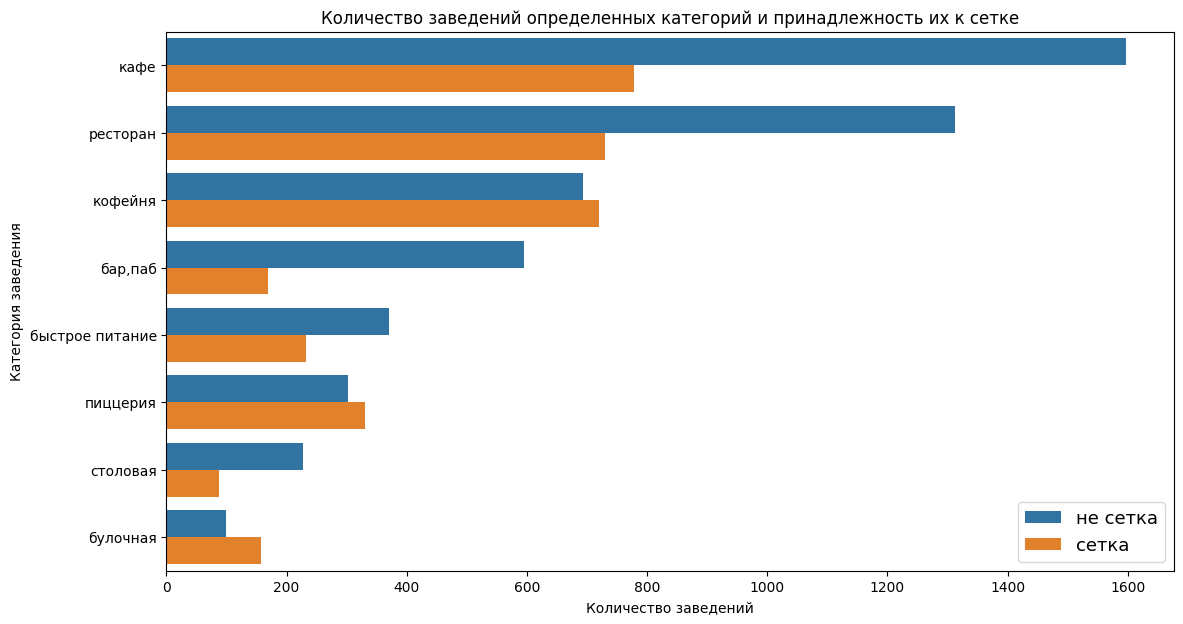

In [17]:
plt.figure(figsize=(13, 7))

sns.barplot(x = 'total_count', y = 'category', hue = 'chain', data = chain_notchain)

plt.title('Количество заведений определенных категорий и принадлежность их к сетке')
plt.xlabel('Количество заведений')
plt.ylabel('Категория заведения')
plt.legend(loc = 'lower right', fontsize = 13)

Вывод: В сетевых и несетевых заведениях чаще всего кафе и рестораны. Это два наиболее популярных формата. Также популярен формат кофеен. Чаще всего сетевыми являются пиццерии, кофейни и булочные.

<div class="alert alert-success">
<h2> Комментарий ревьюера v2<a class="tocSkip"> </h2>

<b>Отлично!✅:</b> Молодец, отличный график и верный вывод!

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v2<a class="tocSkip"> </h2>
    
<b>Можно лучше⚠️:</b> Здесь также стоит в вывод дописать какие сетевые категории преобладают в категориях, учитывая общую выборку. На графике у тебя это хорошо видно.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v3<a class="tocSkip"> </h2>

<b>Отлично!✅:</b> Молодец!
</div>

Сгруппируйте данные по названиям заведений и найдите топ-15 популярных сетей в Москве. Под популярностью понимается количество заведений этой сети в регионе. Постройте подходящую для такой информации визуализацию. Знакомы ли вам эти сети? Есть ли какой-то признак, который их объединяет? К какой категории заведений они относятся?

In [18]:
chain_categories = (data.query('chain == "сетка"')
                        .groupby(['name','category'], as_index = False)[['rating']].count()
                        .sort_values('rating', ascending = False)
                        .head(15))
display(chain_categories)

,name,category,rating
2462,шоколадница,кофейня,28
1135,додо пицца,пиццерия,25
1155,домино'с пицца,пиццерия,23
503,one price coffee,кофейня,18
197,cofix,кофейня,16
1281,кафе,кофейня,14
2507,яндекс лавка,ресторан,14
934,буханка,булочная,13
1280,кафе,кафе,12
1440,кофепорт,кофейня,12


In [19]:
fig_5 = px.bar(chain_categories, x = 'name', y = 'rating')
fig_5.update_xaxes(tickangle = 45)
fig_5.update_layout(title = 'ТОП-15 самых популярных сетевых заведений Москвы',
                   xaxis_title = 'Заведения',
                   yaxis_title = 'Количество заведений')
fig_5.show()

In [20]:
fig_14 = px.bar(chain_categories, x = 'category', y = 'rating', text = 'name')
fig_14.update_xaxes(tickangle = 45)
fig_14.update_layout(title = 'Категории ТОП-15 заведений',
                   xaxis_title = 'Категория заведения',
                   yaxis_title = 'Количество заведений')
fig_14.show()

Вывод: Все сетки довольно такие знакомы. Шоколадница самаяпопулярная сетка. Там и посидеть можно, вкусно покушать и кофе там хороший

<div class="alert alert-success">
<h2> Комментарий ревьюера v2<a class="tocSkip"> </h2>

<b>Отлично!✅:</b> Отлично! Молодец, что не забыл при группировке фильтровать по chain.
</div>

<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v2<a class="tocSkip"></h2>

    
<b>Необходимо исправить❌:</b>
Необходимо добавить график "Категории ТОП-15 заведений".
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v3<a class="tocSkip"> </h2>

<b>Отлично!✅:</b> О, прикольный график!
</div>

Какие административные районы Москвы присутствуют в датасете? Отобразите общее количество заведений и количество заведений каждой категории по районам. Попробуйте проиллюстрировать эту информацию одним графиком.

In [21]:
district_count = data.groupby('district')[['district']].count()
district_count.columns = ['total_count']
district_count = district_count.reset_index()
display(district_count)

,district,total_count
0,Восточный административный округ,798
1,Западный административный округ,851
2,Северный административный округ,900
3,Северо-Восточный административный округ,891
4,Северо-Западный административный округ,409
5,Центральный административный округ,2242
6,Юго-Восточный административный округ,712
7,Юго-Западный административный округ,709
8,Южный административный округ,891


In [22]:
fig_6 = px.bar(district_count.sort_values(by='total_count', ascending=True),
             x = 'total_count',
             y = 'district',
             text = 'total_count')

fig_6.update_layout(title='Районы Москвы и количество заведений',
                   xaxis_title = 'Количество заведений',
                   yaxis_title = 'Район Москвы')
fig_6.show()

Вывод: Данные представлены по всей Москве, кроме районов: Троицкого, Зеленоградского и Новомосковского. В ЦАО больше всего заведений

<div class="alert alert-success">
<h2> Комментарий ревьюера v2<a class="tocSkip"> </h2>

<b>Отлично!✅:</b> Я не из Москвы, поэтому про районы не знаю:)) А так вывод и график верные!
</div>

Визуализируйте распределение средних рейтингов по категориям заведений. Сильно ли различаются усреднённые рейтинги в разных типах общепита?

In [23]:
cat_rating_pivot = (data.pivot_table(index = 'category', values = 'rating', aggfunc = 'mean')
                        .sort_values(by = 'rating', ascending = False))
cat_rating_pivot['rating'] = round(cat_rating_pivot['rating'], 2)
display(cat_rating_pivot)

,rating
category,
"бар,паб",4.39
пиццерия,4.30
ресторан,4.29
кофейня,4.28
булочная,4.27
столовая,4.21
кафе,4.12
быстрое питание,4.05


In [24]:
fig_7 = px.bar(cat_rating_pivot, y = 'rating', text = 'rating')
fig_7.update_layout(title = 'Средний рейтинг категорий заведений в Москве',
                   xaxis_title = 'Тип заведения',
                   yaxis_title = 'Средний рейтинг')
fig_7.show()

Вывод: У всех категорий заведений в целом хороший рейтинг. Но самый лучший средний рейтинг у баров/пабов

<div class="alert alert-success">
<h2> Комментарий ревьюера v2<a class="tocSkip"> </h2>

<b>Отлично!✅:</b> Согласна!
</div>

Постройте фоновую картограмму (хороплет) со средним рейтингом заведений каждого района. Границы районов Москвы, которые встречаются в датасете, хранятся в файле admin_level_geomap.geojson (скачать файл для локальной работы).

In [25]:
dist_rating = (data.pivot_table(index = 'district', values = 'rating', aggfunc = 'mean')
                        .sort_values(by = 'rating', ascending = False))
dist_rating.columns = ['mean_rating']
dist_rating = dist_rating.reset_index()
display(dist_rating)

,district,mean_rating
0,Центральный административный округ,4.377520
1,Северный административный округ,4.239778
2,Северо-Западный административный округ,4.208802
3,Южный административный округ,4.184736
4,Западный административный округ,4.181551
5,Восточный административный округ,4.174185
6,Юго-Западный административный округ,4.172920
7,Северо-Восточный административный округ,4.148260
8,Юго-Восточный административный округ,4.101264


In [26]:
state_geo = '/datasets/admin_level_geomap.geojson'
moscow_lat, moscow_lng = 55.751244, 37.618423

m1 = Map(location=[moscow_lat, moscow_lng], zoom_start=10)

Choropleth(
    geo_data=state_geo,
    data = dist_rating,
    columns = ['district', 'mean_rating'],
    key_on = 'feature.name',
    fill_color = 'BuGn',
    fill_opacity = 0.6,
    legend_name = 'Медианный рейтинг заведений по районам',
).add_to(m1)

m1

FileNotFoundError: ignored

Отобразите все заведения датасета на карте с помощью кластеров средствами библиотеки folium.

In [ ]:
m2 = folium.Map(location=[moscow_lat, moscow_lng])

marker_cluster = MarkerCluster().add_to(m2)
def create_clusters(row):
    Marker(
        [row['lat'], row['lng']],
        popup = f"{row['name']}",
    ).add_to(marker_cluster)

data.apply(create_clusters, axis=1)

m2

Найдите топ-15 улиц по количеству заведений. Постройте график распределения количества заведений и их категорий по этим улицам. Попробуйте проиллюстрировать эту информацию одним графиком.

In [ ]:
street_pivot = data.pivot_table(index = 'street', columns = 'category', values = 'rating', aggfunc = 'count', fill_value = 0)
street_pivot['total'] = street_pivot['бар,паб'] + street_pivot['булочная'] + street_pivot['быстрое питание'] + street_pivot['кафе'] + street_pivot['пиццерия'] + street_pivot['кофейня'] + street_pivot['ресторан'] + street_pivot['столовая']
street_pivot_top_15 = street_pivot.sort_values(by = 'total', ascending = False).head(15)
display(street_pivot_top_15)

In [ ]:
fig_8 = px.bar(street_pivot_top_15, y = 'total', text = 'total')
fig_8.update_xaxes(tickangle = 60)
fig_8.update_layout(title = 'Количество заведений на самых популярных улицах Москвы',
                   xaxis_title = 'Улица',
                   yaxis_title = 'Количество заведений')
fig_8.show()

In [ ]:
data_top15 = (data.query('street == " проспект Мира" or street == " Профсоюзная улица" or street == " проспект Вернадского" or street == " Ленинский проспект" or street == " Ленинградский проспект" or street == " Дмитровское шоссе" or street == " Каширское шоссе" or street == " Варшавское шоссе" or street == " Ленинградское шоссе" or street == " МКАД" or street == " Люблинская улица" or street == " улица Вавилова" or street == " Кутузовский проспект" or street == " улица Миклухо-Маклая" or street == " Пятницкая улица"'))

m3 = folium.Map(location=[moscow_lat, moscow_lng])

marker_cluster = MarkerCluster().add_to(m3)
def create_clusters1(row):
    Marker(
        [row['lat'], row['lng']],
        popup = f"{row['name']}, {row['address']}, {row['rating']}",
    ).add_to(marker_cluster)

data_top15.apply(create_clusters1, axis=1)

m3

Найдите улицы, на которых находится только один объект общепита. Что можно сказать об этих заведениях?

In [ ]:
street_one = data.groupby(['street', 'category'], as_index = False)[['rating']].count()
street_one.columns = ['street', 'category', 'total']
street_one = street_one.query('total == 1')
#display(street_one.count())
street_ones = data.groupby(['street', 'category'])[['rating']].count()
grap = street_ones.groupby('category')[['rating']].sum().sort_values('rating', ascending = False)
#display(grap)

In [ ]:
fig_9 = px.bar(grap)
fig_9.update_layout(title = 'Категории заведений на улицах Москвы с одним заведением',
                   xaxis_title = 'Количество заведений',
                   yaxis_title = 'Тип заведения')
fig_9.show()

Вывод: Больше всего кафе на "одиноких" улицах Москвы, дальше идут кофейни и рестораны. Все наиболее популярные форматы Москвы. Всего таких улиц 2253

Значения средних чеков заведений хранятся в столбце middle_avg_bill. Эти числа показывают примерную стоимость заказа в рублях, которая чаще всего выражена диапазоном. Посчитайте медиану этого столбца для каждого района. Используйте это значение в качестве ценового индикатора района. Постройте фоновую картограмму (хороплет) с полученными значениями для каждого района. Проанализируйте цены в центральном административном округе и других. Как удалённость от центра влияет на цены в заведениях?

In [ ]:
dist_bill = (data.query('middle_avg_bill != 0')
                 .groupby('district', as_index = False)[['middle_avg_bill']].median()
                 .sort_values('middle_avg_bill', ascending = True))
display(dist_bill)

In [ ]:
fig_10 = px.bar(dist_bill, y = 'district', x = 'middle_avg_bill', text = 'middle_avg_bill')
fig_10.update_layout(title = 'Средний чек в заведениях Москвы по районам',
                   xaxis_title = 'Средний чек',
                   yaxis_title = 'Район Москвы')
fig_10.show()

In [ ]:
m4 = Map(location = [moscow_lat, moscow_lng], zoom_start=10)

Choropleth(
    geo_data=state_geo,
    data = dist_bill,
    columns = ['district', 'middle_avg_bill'],
    key_on = 'feature.name',
    fill_color = 'OrRd',
    fill_opacity = 0.2,
    legend_name = 'Медианный рейтинг заведений по районам',
).add_to(m4)

m4

Вывод: В центре Москвы самый дорогой средний чек, также как и в Западном. На Севере, Юге и Юго-Востоке средний чек достаточно низкий.

Ответьте на следующие вопросы:
Сколько всего кофеен в датасете? В каких районах их больше всего, каковы особенности их расположения?
Есть ли круглосуточные кофейни?
Какие у кофеен рейтинги? Как они распределяются по районам?
На какую стоимость чашки капучино стоит ориентироваться при открытии и почему?

# Исследование по открытию кофейни

In [ ]:
cafe_data = data[data['category'] == 'кофейня']
print('Всего кофеен в Москве:')
print(cafe_data['name'].count()) # 1413 всего
print('Количество круглосуточных кофеен в Москве:')
print(cafe_data[cafe_data['is_24/7'] == 1]['name'].count()) # круглосуточных кофеен нет
print('Средний рейтинг кофеен в Москве:')
print(cafe_data['rating'].mean()) # средний рейтинг 4.27728237791932
mean_price = cafe_data.query('middle_coffee_cup != 0')

dist_rating_cafe_pivot = cafe_data.pivot_table(index = 'district', values = 'rating', aggfunc = 'mean')
dist_rating_cafe_count_pivot = cafe_data.pivot_table(index = 'district', values = 'rating', aggfunc = 'count')
dist_cafe_middle = (cafe_data
                        .query('middle_coffee_cup != 0')
                        .groupby('district', as_index = False)[['middle_coffee_cup']].mean()
                        .sort_values('middle_coffee_cup', ascending = False))
dist_cafe_middle['middle_coffee_cup'] = round(dist_cafe_middle['middle_coffee_cup'], 2)
dist_rating_cafe_info = (cafe_data
                             .pivot_table(index = 'district', columns = 'price', values = 'rating', aggfunc = 'mean'))
dist_middle_cafe_info = (cafe_data
                             .query('middle_coffee_cup != 0')
                             .pivot_table(index = 'district', values = 'middle_coffee_cup', aggfunc = 'mean'))
dist_cafe_price_cat_pivot = cafe_data.pivot_table(index = 'price', values = 'rating', aggfunc = 'mean')
data_mean_cafe_price = (cafe_data
                            .groupby('price', as_index = False)[['rating']].mean()
                            .sort_values('rating', ascending = True))

In [ ]:
#display(dist_rating_cafe_pivot) # В целом рейтинг везде хороший. В центре и на севере он повыше
dist_rating_cafe_pivot['rating'] = round(dist_rating_cafe_pivot['rating'], 2)
fig_11 = px.bar(dist_rating_cafe_pivot.sort_values('rating', ascending = False), y = 'rating', text = 'rating')
fig_11.update_xaxes(tickangle = 50)
fig_11.update_layout(title = 'Средний рейтинг кофеен по районам Москвы',
                   xaxis_title = 'Район Москвы',
                   yaxis_title = 'Средний рейтинг')
fig_11.show()

In [ ]:
#display(dist_rating_cafe_count_pivot) # Больше всего кофеен в центре, меньше всего на северо-западе
# График
fig_12 = px.bar(dist_rating_cafe_count_pivot.sort_values('rating', ascending = False), y = 'rating', text = 'rating')
fig_12.update_xaxes(tickangle = 50)
fig_12.update_layout(title = 'Количество кофеен по районам Москвы',
                   xaxis_title = 'Район Москвы',
                   yaxis_title = 'Количество кофеен')
fig_12.show()

In [ ]:
print('По имеющимся данным средний чек за кофе равен:')
print(mean_price['middle_coffee_cup'].mean()) # Средняя цена здесь 105.5
#display(dist_cafe_middle) # По имеющимся данным только из трех округов средняя цена по ним около 101.5
fig_13 = px.bar(dist_cafe_middle, x = 'district', y = 'middle_coffee_cup', text = 'middle_coffee_cup')
fig_13.update_xaxes(tickangle = 50)
fig_13.update_layout(title = 'Данные по средней цене в районах Москвы',
                   xaxis_title = 'Район Москвы',
                   yaxis_title = 'Средняя цена кофе')
fig_13.show()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 4))
sns.lineplot(x = 'price', y = 'rating', data = data_mean_cafe_price, marker='D')
plt.title('График зависимости рейтинга от ценовой категории')
plt.xlabel('Ценовая категория')
plt.ylabel('Средний рейтинг')
plt.show()

In [ ]:
print('Информация по среднему рейтингу в кафе разбитая по ценовым категориям и по районам Москвы')
display(dist_rating_cafe_info)

In [ ]:
print('Информация по среднему чеку в кафе разбитая по ценовым категориям и по районам Москвы')
display(dist_middle_cafe_info)

In [ ]:
m5 = folium.Map(location=[moscow_lat, moscow_lng])

marker_cluster = MarkerCluster().add_to(m5)
def create_clusters1(row):
    Marker(
        [row['lat'], row['lng']],
        popup = f"{row['name']}, {row['address']}, {row['rating']}",
    ).add_to(marker_cluster)

cafe_data.apply(create_clusters1, axis=1)

m5

Вывод: Из данных следует, что в Москве 1413 кофеен. Среди них нет круглосуточных. Средний рейтинг коффен в Москве 4.28. Рейтинг в целом во всех районах Москвы хороший около 4.3. В центре и на севере он немного повыше 4.34 и 4.33 соответственно. В центре болье всего кофеен 428. Средняя цена кофе в Москве около 175 рубля. По имеющимся данным лучше всего рейтинг у кофеен с ценовым показателем высокие 4.44, видна прямая зависимость ценовой категории и рейтинга. Самый лучший рейтинг у кофеен в ЦАО с категорией выше среднего 4.45. Там одна из самых высоких цен на кофе 188. Выше только на Севере около 190 рублей.

# Презентация

https://disk.yandex.ru/d/wW5JCQ9_tTyF0A